In [44]:
%matplotlib notebook
import matplotlib.pyplot as plt     
import numpy as np 
from scipy.interpolate import interp1d
eV = 27.2114

# Example 1: vinylfluoride
### Input-file:

In [45]:
'''
@jobs
task: response
@end

@method settings
xcfun: b3lyp
basis: def2-svp
@end

@response
property: absorption (cpp)
frequencies: 10.05 - 10.37 (0.0025)
damping: 0.01
@end

@molecule
charge: 0
multiplicity: 1
xyz:
 C     0.000000    -0.246412    -1.271068
 C     0.000000     0.457081    -0.154735
 F     0.000000    -0.119195     1.052878
 H     0.000000     0.272328    -2.210194
 H     0.000000    -1.319906    -1.249847
 H     0.000000     1.530323    -0.095954
@end
'''

'\n@jobs\ntask: response\n@end\n\n@method settings\nxcfun: b3lyp\nbasis: def2-svp\n@end\n\n@response\nproperty: absorption (cpp)\nfrequencies: 10.05 - 10.37 (0.0025)\ndamping: 0.01\n@end\n\n@molecule\ncharge: 0\nmultiplicity: 1\nxyz:\n C     0.000000    -0.246412    -1.271068\n C     0.000000     0.457081    -0.154735\n F     0.000000    -0.119195     1.052878\n H     0.000000     0.272328    -2.210194\n H     0.000000    -1.319906    -1.249847\n H     0.000000     1.530323    -0.095954\n@end\n'

## Load data for analysis
Here saved in .npy-object - can alternatively use hdf5

In [46]:
data = np.load('vinylfluoride.npy', allow_pickle=True)
scf_E = data[0][1]; mo_E  = data[1][1]; nocc  = data[2][1]; nvirt = data[3][1]; freqs = data[4][1]
axx   = data[5][1]; ayy   = data[6][1]; azz   = data[7][1]
x_solution = data[8][1]; y_solution = data[9][1]; z_solution = data[10][1]
print('SCF energy:',scf_E)
print('Occupied MO energies:',mo_E[:nocc])

SCF energy: -177.68966209046528
Occupied MO energies: [-24.69342438 -10.27018896 -10.18747364  -1.20405927  -0.76597437
  -0.60515048  -0.53206822  -0.48506863  -0.46039734  -0.41430941
  -0.37450458  -0.26981574]


## Extract spectra (isotropic and for each Cartesian component)
Printing isotropic results - compare to output-file from your calculation

In [47]:
n_freq = len(freqs)
sigma,sxx,syy,szz = np.zeros(n_freq),np.zeros(n_freq),np.zeros(n_freq),np.zeros(n_freq)
print('Freq. [au]  Freq [eV]  Sigma(w) [au]')
indx = 0
for w in freqs:
    axx_tmp = axx[indx]; ayy_tmp = ayy[indx]; azz_tmp = azz[indx]
    a_bar = (axx_tmp + ayy_tmp + azz_tmp) / 3.0
    sigma[indx] = (4.0 * np.pi * w * a_bar   / 137.035999)
    sxx[indx]   = (4.0 * np.pi * w * axx_tmp / 137.035999)
    syy[indx]   = (4.0 * np.pi * w * ayy_tmp / 137.035999)
    szz[indx]   = (4.0 * np.pi * w * azz_tmp / 137.035999)
    print(' {0:.4f}    {1:.4f}    {2:.8f}'.format(w,w*eV, sigma[indx]))
    indx += 1

Freq. [au]  Freq [eV]  Sigma(w) [au]
 10.0500    273.4746    0.00845762
 10.0525    273.5426    0.00899523
 10.0550    273.6106    0.00960043
 10.0575    273.6787    0.01028567
 10.0600    273.7467    0.01106644
 10.0625    273.8147    0.01196217
 10.0650    273.8827    0.01299751
 10.0675    273.9508    0.01420404
 10.0700    274.0188    0.01562271
 10.0725    274.0868    0.01730729
 10.0750    274.1549    0.01932928
 10.0775    274.2229    0.02178513
 10.0800    274.2909    0.02480674
 10.0825    274.3589    0.02857705
 10.0850    274.4270    0.03335308
 10.0875    274.4950    0.03949933
 10.0900    274.5630    0.04753392
 10.0925    274.6311    0.05818320
 10.0950    274.6991    0.07241525
 10.0975    274.7671    0.09134172
 10.1000    274.8351    0.11567469
 10.1025    274.9032    0.14413677
 10.1050    274.9712    0.17074302
 10.1075    275.0392    0.18447787
 10.1100    275.1073    0.17750124
 10.1125    275.1753    0.15429935
 10.1150    275.2433    0.12619319
 10.1175    275.31

## Compare to experiment
Plotting above results as well as line spectrum constructed with a cubic spline.\
Results shifted to align with first experimental feature.

<IPython.core.display.Javascript object>


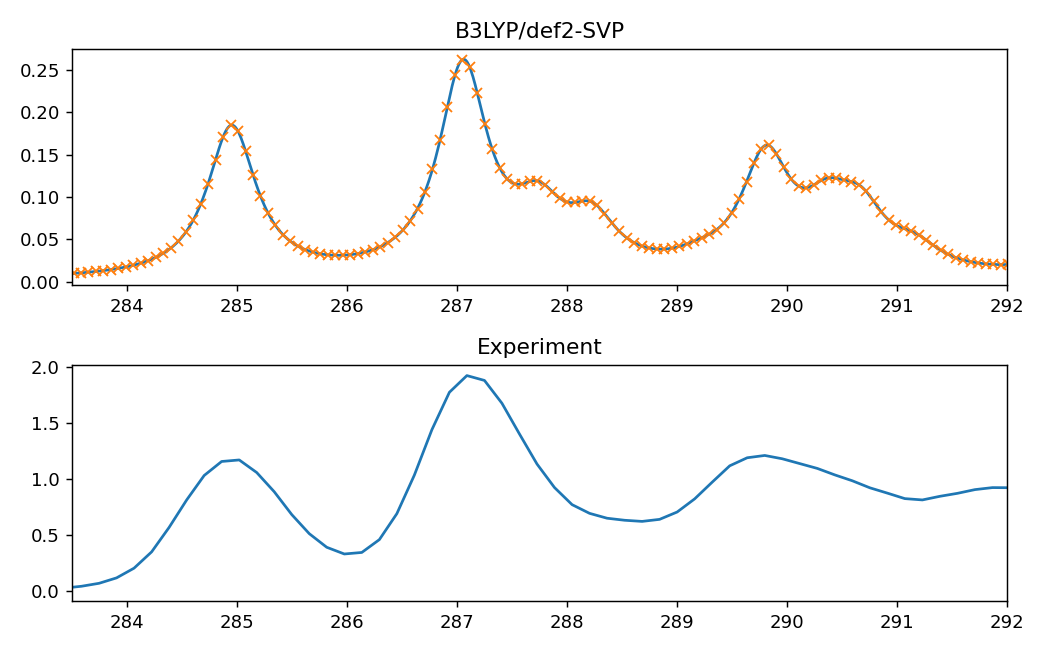

In [48]:
data = np.loadtxt('expt_vin'); E,I = [],[]
for i in np.arange(len(data)): E.append(data[i][0]); I.append(data[i][1])
x = np.arange(min(freqs*eV),max(freqs*eV),0.01)
y = interp1d(freqs*eV, sigma, kind='cubic')
xmin,xmax = 283.5,292
plt.figure(figsize=(8,5))
plt.subplot(211); plt.title('B3LYP/def2-SVP')
shft = 275.05-284.95
plt.plot(x-shft,y(x))
plt.plot(freqs*eV-shft,sigma,'x')
plt.xlim((xmin,xmax))
plt.subplot(212); plt.title('Experiment')
plt.plot(E,I); plt.xlim((xmin,xmax))
plt.tight_layout(); plt.show()

## Resolving cartesian components
Dominated by out-of-plane contributions due to $1s \rightarrow \pi^{\ast}$ transitions.\
(Note the factor of 1/3 for the components, which is there to make the sum equal to the isotropic average)

<IPython.core.display.Javascript object>


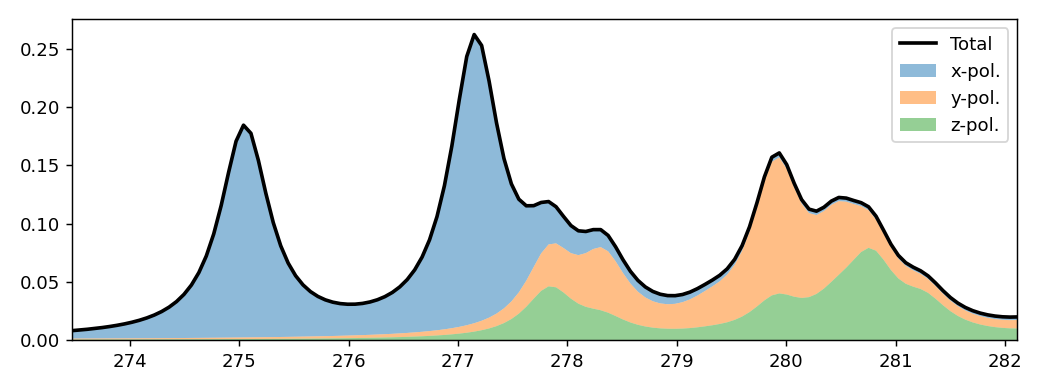

In [49]:
plt.figure(figsize=(8,3))
plt.plot(freqs*eV,sigma,linewidth=2,color='k')
plt.fill_between(freqs*eV,(sxx+syy+szz)/3.,(syy+szz)/3.,alpha=0.5)
plt.fill_between(freqs*eV,(syy+szz)/3.,(szz)/3.,alpha=0.5)
plt.fill_between(freqs*eV,(szz)/3.,alpha=0.5)
plt.legend(('Total','x-pol.','y-pol.','z-pol.'))
plt.xlim((eV*min(freqs),eV*max(freqs))); plt.ylim((0,1.05*max(sigma))); plt.tight_layout()

## Resolving the atomic contributions to the spectrum
- Extract information for each solution vector (one per cartesian component)
- Sum contributions from each occupied orbital, normalized by all contributions
- Scale with corresponding cartesian component and sum up

### For vinylfluoride
- Two strong $1s \rightarrow \pi^{\ast}$ transitions from each carbon 1s
- Bond to electronegative fluoride decrease electron density around carbon, leading to higher transition energy for that carbon
    - Results in chemical shift of about 2 eV between -CH$_2$ (MO #3 )and -CFH (MO #2)

<IPython.core.display.Javascript object>


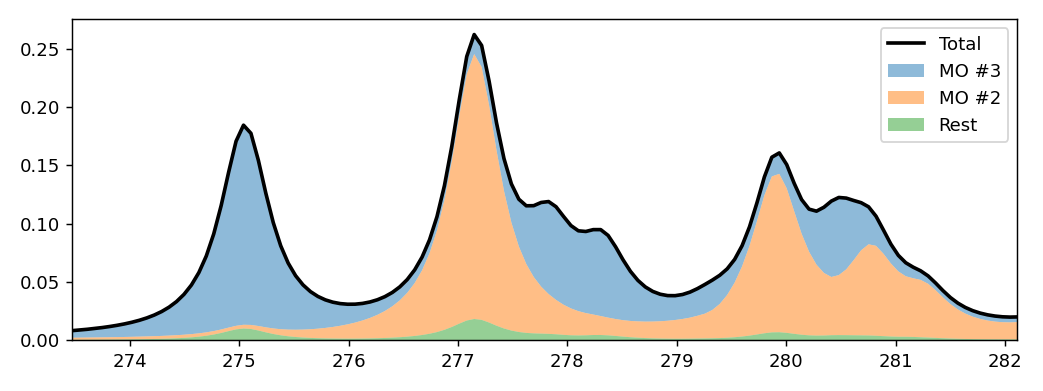

In [50]:
spec_comp = []
for occ in np.arange(0,nocc): spec_comp.append([])
for i in np.arange(len(freqs)):
    x_tmp = x_solution[i]; y_tmp = y_solution[i]; z_tmp = z_solution[i]
    for occ in np.arange(0,nocc):
        comp_X = np.sum(np.abs(np.imag(x_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(x_tmp[:])))
        comp_Y = np.sum(np.abs(np.imag(y_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(y_tmp[:])))
        comp_Z = np.sum(np.abs(np.imag(z_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(z_tmp[:])))
        spec_comp[occ].append((comp_X*sxx[i]+comp_Y*syy[i]+comp_Z*szz[i])/3.)
plt.figure(figsize=(8,3))
mo2 = np.array(spec_comp[1]); mo3 = np.array(spec_comp[2])
plt.plot(eV*freqs,sigma,linewidth=2,color='k')
plt.fill_between(eV*freqs,sigma,sigma-mo3,alpha=0.5)
plt.fill_between(eV*freqs,sigma-mo3,sigma-mo2-mo3,alpha=0.5)
plt.fill_between(eV*freqs,sigma-mo2-mo3,alpha=0.5)
plt.legend(('Total','MO #3','MO #2','Rest'))
plt.xlim((eV*min(freqs),eV*max(freqs))); plt.ylim((0,1.05*max(sigma))); plt.tight_layout()

# Example 2: free-based porphyrin
### Input-file:

In [51]:
'''
@jobs
task: response
@end

@method settings
xcfun: b3lyp
basis: def2-svp
@end

@response
property: absorption (cpp)
frequencies: 10.01 - 10.17 (0.0016)
@end

@molecule
charge: 0
multiplicity: 1
xyz:
H 3.209599995 3.172309777 0.000000000
N 0.000000000 -2.113600613 0.000000000
N 2.031813914 0.000000000 0.000000000
N 0.000000000 2.113600613 0.000000000
N -2.031813914 0.000000000 0.000000000
C 1.126850920 -2.888627221 0.000000000
C -1.126850920 -2.888627221 0.000000000
C 1.126850920 2.888627221 0.000000000
C -1.126850920 2.888627221 0.000000000
C 2.850160984 -1.083939750 0.000000000
C 2.850160984 1.083939750 0.000000000
C -2.850160984 -1.083939750 0.000000000
C -2.850160984 1.083939750 0.000000000
C 0.683827200 -4.249372023 0.000000000
C -0.683827200 -4.249372023 0.000000000
C 0.683827200 4.249372023 0.000000000
C -0.683827200 4.249372023 0.000000000
C 4.248378966 -0.675836785 0.000000000
C 4.248378966 0.675836785 0.000000000
C -4.248378966 -0.675836785 0.000000000
C -4.248378966 0.675836785 0.000000000
C 2.433989580 -2.416542873 0.000000000
C -2.433989580 -2.416542873 0.000000000
C -2.433989580 2.416542873 0.000000000
C 2.433989580 2.416542873 0.000000000
H 1.341416542 -5.103998738 0.000000000
H -1.341416542 -5.103998738 0.000000000
H 1.341416542 5.103998738 0.000000000
H -1.341416542 5.103998738 0.000000000
H 5.096138011 -1.344322017 0.000000000
H 5.096138011 1.344322017 0.000000000
H -5.096138011 -1.344322017 0.000000000
H -5.096138011 1.344322017 0.000000000
H 3.209599995 -3.172309777 0.000000000
H -3.209599995 -3.172309777 0.000000000
H -3.209599995 3.172309777 0.000000000
H 0.000000000 -1.102285542 0.000000000
H 0.000000000 1.102285542 0.000000000
@end
'''

'\n@jobs\ntask: response\n@end\n\n@method settings\nxcfun: b3lyp\nbasis: def2-svp\n@end\n\n@response\nproperty: absorption (cpp)\nfrequencies: 10.01 - 10.17 (0.0016)\n@end\n\n@molecule\ncharge: 0\nmultiplicity: 1\nxyz:\nH 3.209599995 3.172309777 0.000000000\nN 0.000000000 -2.113600613 0.000000000\nN 2.031813914 0.000000000 0.000000000\nN 0.000000000 2.113600613 0.000000000\nN -2.031813914 0.000000000 0.000000000\nC 1.126850920 -2.888627221 0.000000000\nC -1.126850920 -2.888627221 0.000000000\nC 1.126850920 2.888627221 0.000000000\nC -1.126850920 2.888627221 0.000000000\nC 2.850160984 -1.083939750 0.000000000\nC 2.850160984 1.083939750 0.000000000\nC -2.850160984 -1.083939750 0.000000000\nC -2.850160984 1.083939750 0.000000000\nC 0.683827200 -4.249372023 0.000000000\nC -0.683827200 -4.249372023 0.000000000\nC 0.683827200 4.249372023 0.000000000\nC -0.683827200 4.249372023 0.000000000\nC 4.248378966 -0.675836785 0.000000000\nC 4.248378966 0.675836785 0.000000000\nC -4.248378966 -0.675836

In [52]:
data = np.load('vinylfluoride.npy', allow_pickle=True)
scf_E = data[0][1]; mo_E  = data[1][1]; nocc  = data[2][1]; nvirt = data[3][1]; freqs = data[4][1]
axx   = data[5][1]; ayy   = data[6][1]; azz   = data[7][1]
x_solution = data[8][1]; y_solution = data[9][1]; z_solution = data[10][1]
print('SCF energy:',scf_E)
print('Occupied MO energies:',mo_E[:nocc])

SCF energy: -177.68966209046528
Occupied MO energies: [-24.69342438 -10.27018896 -10.18747364  -1.20405927  -0.76597437
  -0.60515048  -0.53206822  -0.48506863  -0.46039734  -0.41430941
  -0.37450458  -0.26981574]


## Extract spectra (isotropic and for each Cartesian component)
Printing isotropic results - compare to output-file from your calculation

In [53]:
n_freq = len(freqs)
sigma,sxx,syy,szz = np.zeros(n_freq),np.zeros(n_freq),np.zeros(n_freq),np.zeros(n_freq)
print('Freq. [au]  Freq [eV]  Sigma(w) [au]')
indx = 0
for w in freqs:
    axx_tmp = axx[indx]; ayy_tmp = ayy[indx]; azz_tmp = azz[indx]
    a_bar = (axx_tmp + ayy_tmp + azz_tmp) / 3.0
    sigma[indx] = (4.0 * np.pi * w * a_bar   / 137.035999)
    sxx[indx]   = (4.0 * np.pi * w * axx_tmp / 137.035999)
    syy[indx]   = (4.0 * np.pi * w * ayy_tmp / 137.035999)
    szz[indx]   = (4.0 * np.pi * w * azz_tmp / 137.035999)
    print(' {0:.4f}    {1:.4f}    {2:.8f}'.format(w,w*eV, sigma[indx]))
    indx += 1

Freq. [au]  Freq [eV]  Sigma(w) [au]
 10.0500    273.4746    0.00845762
 10.0525    273.5426    0.00899523
 10.0550    273.6106    0.00960043
 10.0575    273.6787    0.01028567
 10.0600    273.7467    0.01106644
 10.0625    273.8147    0.01196217
 10.0650    273.8827    0.01299751
 10.0675    273.9508    0.01420404
 10.0700    274.0188    0.01562271
 10.0725    274.0868    0.01730729
 10.0750    274.1549    0.01932928
 10.0775    274.2229    0.02178513
 10.0800    274.2909    0.02480674
 10.0825    274.3589    0.02857705
 10.0850    274.4270    0.03335308
 10.0875    274.4950    0.03949933
 10.0900    274.5630    0.04753392
 10.0925    274.6311    0.05818320
 10.0950    274.6991    0.07241525
 10.0975    274.7671    0.09134172
 10.1000    274.8351    0.11567469
 10.1025    274.9032    0.14413677
 10.1050    274.9712    0.17074302
 10.1075    275.0392    0.18447787
 10.1100    275.1073    0.17750124
 10.1125    275.1753    0.15429935
 10.1150    275.2433    0.12619319
 10.1175    275.31

## Compare to experiment
Plotting above results as well as line spectrum constructed with a cubic spline.\
Results shifted to align with first experimental feature.

<IPython.core.display.Javascript object>


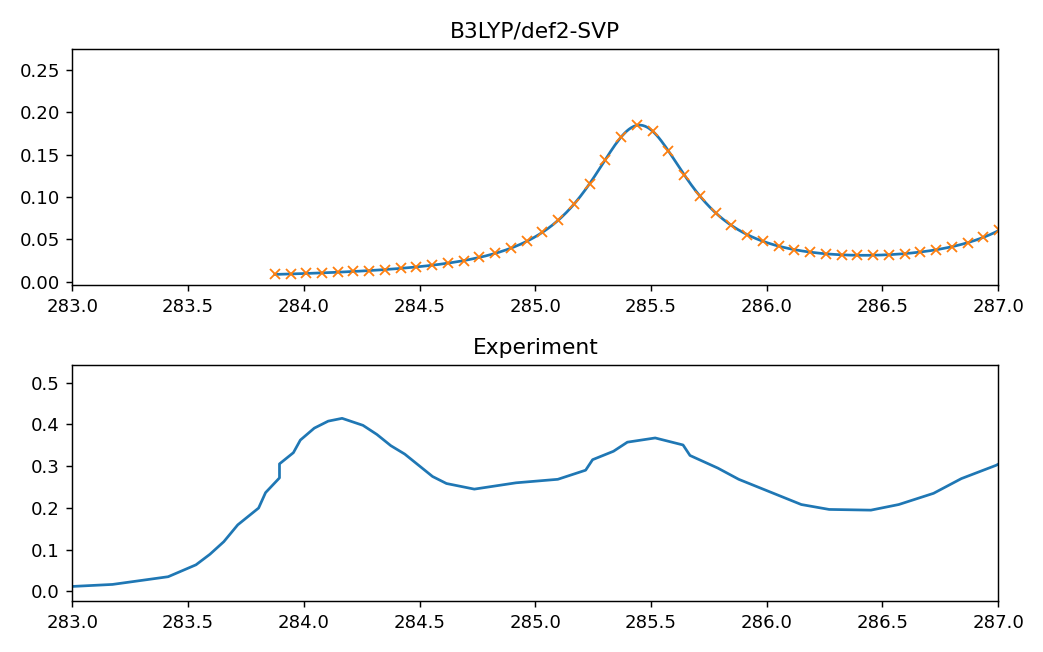

In [59]:
data = np.loadtxt('expt_h2p_25'); E,I = [],[]
for i in np.arange(len(data)): E.append(data[i][0]); I.append(data[i][1])
x = np.arange(min(freqs*eV),max(freqs*eV),0.01)
y = interp1d(freqs*eV, sigma, kind='cubic')
xmin,xmax = 283,287
plt.figure(figsize=(8,5))
plt.subplot(211); plt.title('B3LYP/def2-SVP')
shft = 273.7-284.1
plt.plot(x-shft,y(x))
plt.plot(freqs*eV-shft,sigma,'x')
plt.xlim((xmin,xmax))
plt.subplot(212); plt.title('Experiment')
plt.plot(E,I); plt.xlim((xmin,xmax))
plt.tight_layout(); plt.show()

## Resolving cartesian components
Dominated by out-of-plane contributions due to $1s \rightarrow \pi^{\ast}$ transitions.\
(Note the factor of 1/3 for the components, which is there to make the sum equal to the isotropic average)

<IPython.core.display.Javascript object>


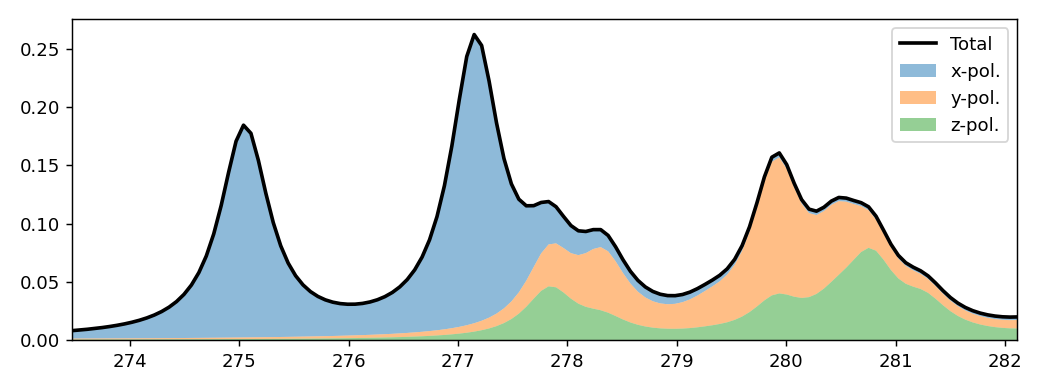

In [55]:
plt.figure(figsize=(8,3))
plt.plot(freqs*eV,sigma,linewidth=2,color='k')
plt.fill_between(freqs*eV,(sxx+syy+szz)/3.,(syy+szz)/3.,alpha=0.5)
plt.fill_between(freqs*eV,(syy+szz)/3.,(szz)/3.,alpha=0.5)
plt.fill_between(freqs*eV,(szz)/3.,alpha=0.5)
plt.legend(('Total','x-pol.','y-pol.','z-pol.'))
plt.xlim((eV*min(freqs),eV*max(freqs))); plt.ylim((0,1.05*max(sigma))); plt.tight_layout()

## Resolving the atomic contributions to the spectrum
- Extract information for each solution vector (one per cartesian component)
- Sum contributions from each occupied orbital, normalized by all contributions
- Scale with corresponding cartesian component and sum up

### For free-based porphyrin
- Two strong $1s \rightarrow \pi^{\ast}$ transitions from each carbon 1s
- Bond to electronegative fluoride decrease electron density around carbon, leading to higher transition energy for that carbon
    - Results in chemical shift of about 2 eV between -CH$_2$ (MO #3 )and -CFH (MO #2)

<IPython.core.display.Javascript object>


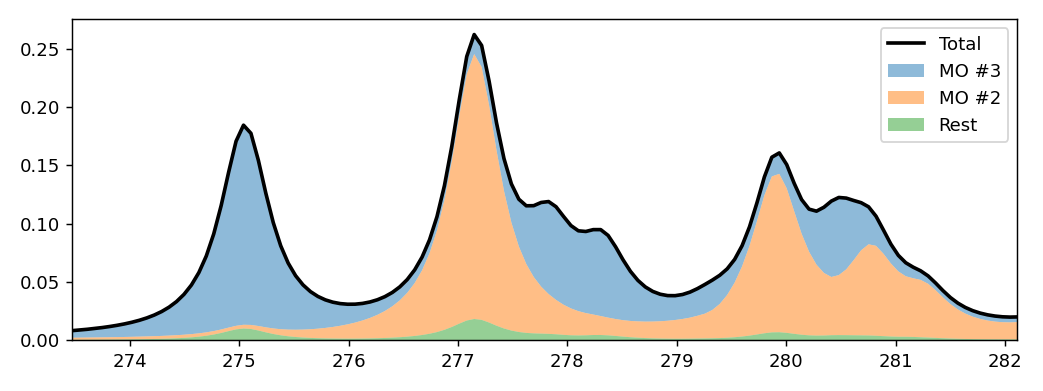

In [56]:
spec_comp = []
for occ in np.arange(0,nocc): spec_comp.append([])
for i in np.arange(len(freqs)):
    x_tmp = x_solution[i]; y_tmp = y_solution[i]; z_tmp = z_solution[i]
    for occ in np.arange(0,nocc):
        comp_X = np.sum(np.abs(np.imag(x_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(x_tmp[:])))
        comp_Y = np.sum(np.abs(np.imag(y_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(y_tmp[:])))
        comp_Z = np.sum(np.abs(np.imag(z_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(z_tmp[:])))
        spec_comp[occ].append((comp_X*sxx[i]+comp_Y*syy[i]+comp_Z*szz[i])/3.)
plt.figure(figsize=(8,3))
mo2 = np.array(spec_comp[1]); mo3 = np.array(spec_comp[2])
plt.plot(eV*freqs,sigma,linewidth=2,color='k')
plt.fill_between(eV*freqs,sigma,sigma-mo3,alpha=0.5)
plt.fill_between(eV*freqs,sigma-mo3,sigma-mo2-mo3,alpha=0.5)
plt.fill_between(eV*freqs,sigma-mo2-mo3,alpha=0.5)
plt.legend(('Total','MO #3','MO #2','Rest'))
plt.xlim((eV*min(freqs),eV*max(freqs))); plt.ylim((0,1.05*max(sigma))); plt.tight_layout()

# Code for running vinylfluoride in Notebook
See for how to extract properties\
Note: quite slow on Binder!

In [57]:
'''
import veloxchem as vlx
from mpi4py import MPI
from veloxchem.rsplinabscross import LinearAbsorptionCrossSection
from veloxchem import OutputStream
comm = MPI.COMM_WORLD
ostream = OutputStream()
mol_str = """
 C     0.000000    -0.246412    -1.271068
 C     0.000000     0.457081    -0.154735
 F     0.000000    -0.119195     1.052878
 H     0.000000     0.272328    -2.210194
 H     0.000000    -1.319906    -1.249847
 H     0.000000     1.530323    -0.095954
"""
molecule = vlx.Molecule.read_str(mol_str)
basis    = vlx.MolecularBasis.read(molecule, "def2-svp")
scf_settings    = {'conv_thresh': 1.0e-8}
method_settings = {'xcfun': 'b3lyp', 'grid_level': 4}
scf_drv = vlx.ScfRestrictedDriver(comm,ostream)
scf_drv.update_settings(scf_settings, method_settings)
scf_drv.compute(molecule, basis)
freqs = np.arange(10.05,10.37,0.0025)
freqs_str = [str(x) for x in freqs]
cpp_prop = LinearAbsorptionCrossSection({'frequencies': ','.join(freqs_str), 'damping': 0.01},method_settings)
cpp_prop.init_driver(comm, ostream)
cpp_prop.compute(molecule, basis, scf_drv.scf_tensors)
axx,ayy,azz = [],[],[]
for w in freqs:
    axx.append(-cpp_prop.rsp_property['response_functions'][('x', 'x', w)].imag)
    ayy.append(-cpp_prop.rsp_property['response_functions'][('y', 'y', w)].imag)
    azz.append(-cpp_prop.rsp_property['response_functions'][('z', 'z', w)].imag)
axx,ayy,azz = np.array(axx),np.array(ayy),np.array(azz)
solution_vecs = cpp_prop.get_property('solutions')
x_solution,y_solution,z_solution = [],[],[]
for w in freqs:
    x_solution.append(solution_vecs[('x',w)]); y_solution.append(solution_vecs[('y',w)]); z_solution.append(solution_vecs[('z',w)])
x_solution,x_solution,x_solution = np.array(x_solution),np.array(y_solution),np.array(z_solution)
nocc  = molecule.number_of_alpha_electrons()
nvirt = scf_drv.mol_orbs.number_mos() - nocc
mo_E  = scf_drv.scf_tensors['E']
scf_E = scf_drv.get_scf_energy()
'''

'\nimport veloxchem as vlx\nfrom mpi4py import MPI\nfrom veloxchem.rsplinabscross import LinearAbsorptionCrossSection\nfrom veloxchem import OutputStream\ncomm = MPI.COMM_WORLD\nostream = OutputStream()\nmol_str = """\n C     0.000000    -0.246412    -1.271068\n C     0.000000     0.457081    -0.154735\n F     0.000000    -0.119195     1.052878\n H     0.000000     0.272328    -2.210194\n H     0.000000    -1.319906    -1.249847\n H     0.000000     1.530323    -0.095954\n"""\nmolecule = vlx.Molecule.read_str(mol_str)\nbasis    = vlx.MolecularBasis.read(molecule, "def2-svp")\nscf_settings    = {\'conv_thresh\': 1.0e-8}\nmethod_settings = {\'xcfun\': \'b3lyp\', \'grid_level\': 4}\nscf_drv = vlx.ScfRestrictedDriver(comm,ostream)\nscf_drv.update_settings(scf_settings, method_settings)\nscf_drv.compute(molecule, basis)\nfreqs = np.arange(10.05,10.37,0.0025)\nfreqs_str = [str(x) for x in freqs]\ncpp_prop = LinearAbsorptionCrossSection({\'frequencies\': \',\'.join(freqs_str), \'damping\': 0.